# Task 2: Clustering

In [137]:
import pandas as pd
import matplotlib.pyplot as plt

## Loading the RFM model

In [138]:
rfm = pd.read_csv('../dataset/rfm_customer_supermarket_model.csv', sep='\t', index_col=0)
rfm

,monetary,recency,T,frequency,R,F,M,RFMScore
CustomerID,,,,,,,,
12747.0,5.762366,2.079442,5.831882,5.985119,1,3,4,8
12748.0,5.814429,4.584967,5.828946,5.636840,1,2,4,7
12749.0,5.746523,1.098612,5.817111,6.595348,2,4,4,10
12820.0,5.642262,1.098612,5.789960,5.550605,2,2,4,8
12822.0,2.839078,0.000000,4.477337,5.553270,4,2,1,7
...,...,...,...,...,...,...,...,...
18272.0,5.407620,1.609438,5.420535,6.305677,2,4,3,9
18273.0,4.673763,0.693147,5.552960,4.338597,3,1,1,5
18282.0,4.443827,0.000000,5.707110,4.608265,4,1,1,6


In [139]:
rfm = rfm.to_numpy()

## K-means

In [140]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

In [141]:
n_clusters = 2
kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
clusters_customers = kmeans.fit_predict(rfm)
silhouette_avg = silhouette_score(rfm, clusters_customers)
print('average silhouette score: {:<.3f}'.format(silhouette_avg))

average silhouette score: 0.310


In [142]:
def silhouette_scorer(pipeline, X):
    pipeline.fit(X)
    cluster_labels = pipeline['kmeans'].labels_
    return silhouette_score(X, cluster_labels)
    
# define a pipeline to search for the best combination of PCA truncation, scaler and the number of kmeans clusters
pipeline = Pipeline(steps=[('pca', PCA()),
                           ('scaler', StandardScaler()),
                           ('kmeans', KMeans(init='k-means++'))])

n_features = rfm.shape[1]

# parameters of pipelines can be set using ‘__’ separated parameter names
tuned_parameters = {
    'pca__n_components': range(2, n_features + 1),
    'kmeans__n_clusters': range(2, 10)}

search = GridSearchCV(estimator=pipeline, 
                      param_grid=tuned_parameters, 
                      scoring=silhouette_scorer, 
                      cv=[(slice(None), slice(None))],  # https://stackoverflow.com/a/44682305/5555994
                      n_jobs=-1,  # use all processors
                      refit=True, 
                      verbose=True).fit(rfm)

Fitting 1 folds for each of 56 candidates, totalling 56 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    5.8s finished


In [143]:
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score')

def highlight_equal(s, value, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] == value
    return ['background-color: lightyellow' if is_max.any() else '' for v in is_max]

results.head(10).style.apply(highlight_equal, value=1, column=['rank_test_score'], axis=1).hide_index()

params,mean_test_score,rank_test_score
"{'kmeans__n_clusters': 3, 'pca__n_components': 2}",0.300486,1
"{'kmeans__n_clusters': 4, 'pca__n_components': 2}",0.285416,2
"{'kmeans__n_clusters': 2, 'pca__n_components': 2}",0.280826,3
"{'kmeans__n_clusters': 2, 'pca__n_components': 3}",0.274692,4
"{'kmeans__n_clusters': 2, 'pca__n_components': 7}",0.274692,4
"{'kmeans__n_clusters': 2, 'pca__n_components': 8}",0.274692,4
"{'kmeans__n_clusters': 2, 'pca__n_components': 5}",0.271973,7
"{'kmeans__n_clusters': 2, 'pca__n_components': 4}",0.271523,8
"{'kmeans__n_clusters': 5, 'pca__n_components': 2}",0.270299,9
"{'kmeans__n_clusters': 5, 'pca__n_components': 3}",0.270044,10


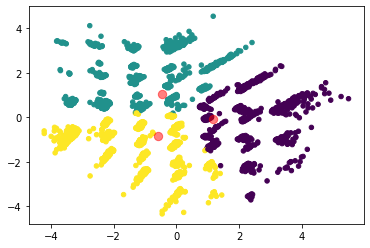

In [147]:
# create a scatter plot
clusters_customers = search.predict(rfm)
pca_rfm = search.best_estimator_['pca'].transform(rfm)
plt.scatter(pca_rfm[:, 0], pca_rfm[:, 1], c=clusters_customers, s=20)
# select cluster centers
centroids = search.best_estimator_['kmeans'].cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);